O modelo salvo após o treinamento da rede neural está armazenado no drive, pois contém 355 MB.

[Baixar modelo_unet.keras](https://drive.google.com/file/d/1HvC_DceK5DHiP7mQzZGtwoQzEYjKrfIu/view?usp=sharing)

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm # Mostrar barra de progresso
import matplotlib.pyplot as plt
import tensorflow
import keras
import random
tensorflow.__version__

'2.18.0'

### Pré-processamento dos dados de treino, validação e teste

Para o nosso caso específico, os nossos dados de teste não contém rótulos, ou seja, só temos o X.

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

SEED = 42 # Definindo seed para reprodutibilidade de resultados
np.random.seed = SEED
random.seed = SEED

PATH_TRAIN = 'data/train/'
PATH_TEST = 'data/test/'

In [3]:
# Adquirimos todos os Ids (caminhos) das imagens de treino e teste
train_ids = next(os.walk(PATH_TRAIN))[1] # Estamos pegando o 2° elemento
test_ids = next(os.walk(PATH_TEST))[1]

In [4]:
# Criando um array composto de zeros onde:
#                       qtd de imagens   altura     largura    canais (rgb)
dataset_img = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Fazemos a mesma coisa para as máscaras, porém com apenas 1 canal e o tipo de dados booleano (0 e 1)
dataset_mask = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

dataset_img.shape, dataset_mask.shape # A única diferença é o número de canais

((670, 256, 256, 3), (670, 256, 256, 1))

In [5]:
# Percorre todas as imagens de treino
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = PATH_TRAIN + id_ # Path de cada imagem

    if '.' in path: # Ignorando arquivos .ipynb_checkpoints gerado pelo notebook
        continue

    img = cv2.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS] # Seleciona apenas os 3 primeiros canais da imagem
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # Todas as imagens devem ficar em uma resolução padrão (no caso, 256x256)
    dataset_img[n] = img

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    # Percorre cada uma das imagens na pasta masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = cv2.imread(path + '/masks/' + mask_file)
        mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY) # Converte para escala de cinza
        mask_ = np.expand_dims(cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH)), axis=-1) # axis=-1 para adicionarmos mais uma dimensão no final do vetor

        # Atualiza a variável mask com a nova máscara do loop na variável mask_
        # No final, as máscaras serão concatenadas em uma só imagem
        mask = np.maximum(mask, mask_)

    dataset_mask[n] = mask


100%|██████████| 670/670 [00:54<00:00, 12.18it/s]


In [6]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [7]:
# Percorre todas as imagens de teste
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = PATH_TEST + id_ # Path de cada imagem

    if '.' in path: # Ignorando arquivos .ipynb_checkpoints gerado pelo notebook
        continue

    img = cv2.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS] # Seleciona apenas os 3 primeiros canais da imagem
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # Todas as imagens devem ficar em uma resolução padrão (no caso, 256x256)
    X_test[n] = img

print(X_test.shape)

100%|██████████| 65/65 [00:00<00:00, 223.37it/s]

(65, 256, 256, 3)


**Separação dos dados entre treino e validação, para adquirir apenas as imagens de validação, da mesma forma que fizemos no notebook de treinamento**

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dataset_img, dataset_mask,
                                                  test_size=0.2,
                                                  random_state=SEED)

### Visualização de algumas imagens de teste

In [9]:
def show_image(img):
    plt.figure(figsize=(12,6))
    plt.axis('off')
    plt.imshow(img)

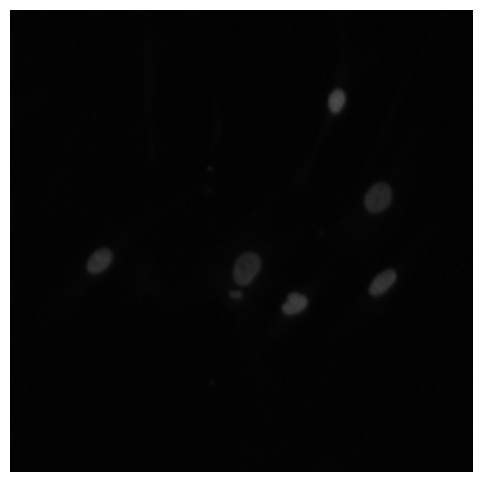

In [10]:
show_image(X_test[0])

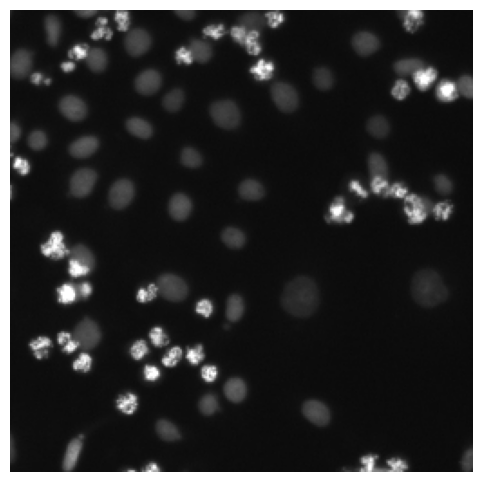

In [11]:
show_image(X_test[64])

In [12]:
model_unet = keras.models.load_model('modelo_unet.keras')
model_unet.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 93,142,341 (355.31 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

 Optimizer params: 62,087,044 (236.84 MB)

### Dados de teste

In [13]:
# Função para realizar comparação entre imagem original e previsão do modelo
def compare_segmentations_test(original_img, predict):
    fig = plt.figure(figsize=(12,6))
    
    fig.add_subplot(1,2,1) # 1 linha, 2 colunas, índice 1
    plt.imshow(original_img)
    plt.axis('off')
    plt.title('Imagem Original')

    fig.add_subplot(1,2,2) # 1 linha, 2 colunas, índice 2
    plt.imshow(np.squeeze(predict))
    plt.axis('off')
    plt.title('Predição')

In [14]:
predicts_test = model_unet.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step


Como resultado da previsão, temos 65 imagens, de 256x256 pixels com apenas 1 canal (escala de cinza).

O modelo previu as máscaras para cada imagem de teste.

In [15]:
predicts_test.shape

(65, 256, 256, 1)

Pelo fato da função de ativação da camada de saída da rede neural ser uma função *sigmoid*, o retorno para cada elemento (pixel) será um valor dentro do intervalo de 0 a 1. Para o nosso contexto, o valor 0 seria o fundo da imagem, o valor mais próximo de 1 será o objeto segmentado.

Valor mínimo e máximo para a primeira previsão.

In [16]:
predicts_test[0].min(), predicts_test[0].max()

(np.float32(0.0046323957), np.float32(1.0))

Portanto, é necessário converter esses valores entre 0 e 1 para somente, 0 ou 1.

A verificação abaixo é uma condicional, onde caso o valor do elemento seja maior do que 0.5, será 1 (ou true) e caso for menor será 0 (ou false). No final, convertemos o true/false para números inteiros (zero ou um).

In [17]:
predicts_test = (predicts_test > 0.5).astype(np.uint8) # Converte true/false para apenas 0 e 1
predicts_test[0].min(), predicts_test[0].max()

(np.uint8(0), np.uint8(1))

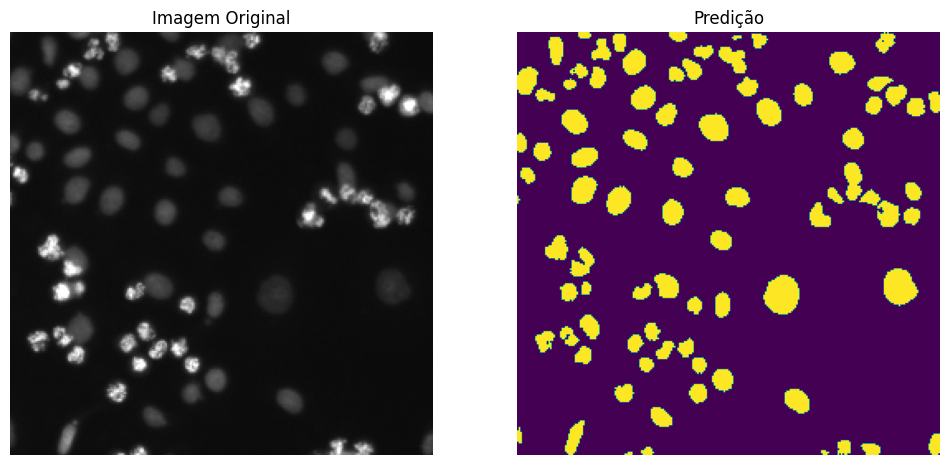

In [18]:
idx_test = 64
compare_segmentations_test(X_test[idx_test], predicts_test[idx_test])

### Dados de validação

In [19]:
# Função para realizar comparação entre imagem original, mascará original e previsão do modelo
def compare_segmentations(original_img, ground_truth, predict):
    fig = plt.figure(figsize=(12,6))
    
    fig.add_subplot(1,3,1) # 1 linha, 3 colunas, índice 1
    plt.imshow(original_img)
    plt.axis('off')
    plt.title('Imagem Original')

    fig.add_subplot(1,3,2) # 1 linha, 3 colunas, índice 2
    # Squeeze para remover a terceira dimensão (canal), pois a imagem já esta em escala de cinza, precisamos apenas da resolução
    plt.imshow(np.squeeze(ground_truth))
    plt.axis('off')
    plt.title('Máscara Original (Ground Truth)')

    fig.add_subplot(1,3,3) # 1 linha, 3 colunas, índice 3
    plt.imshow(np.squeeze(predict))
    plt.axis('off')
    plt.title('Predição')

In [79]:
predicts_val = model_unet.predict(X_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step


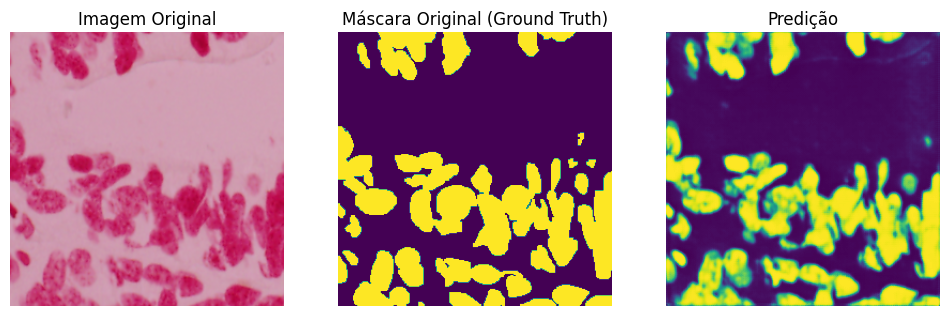

In [21]:
idx = 50
compare_segmentations(X_val[idx], y_val[idx], predicts_val[idx])

### Métricas para avaliação

**Intersection over Union (IoU - Intersecção sobre União)**
- Intersection over Union (IoU), também referenciado como índice de Jaccard, é uma métrica de avaliação usada para medir a precisão de modelos de **segmentação de imagem**.
- Além disso, é uma métrica frequentemente usada também na avaliação de desafios de **detecção de objetos**.
- **Quanto mais próximo de 1, melhor é o resultado desta métrica**.

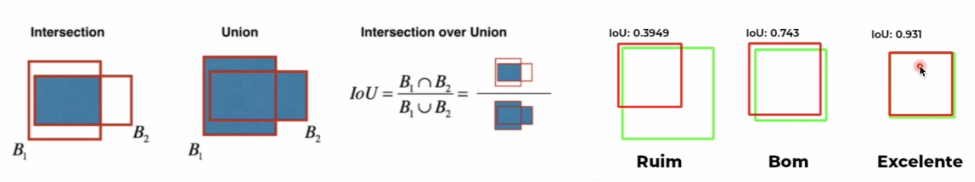

**Pixel Accuracy - Acurácia de pixel / Precisão de pixel**
- É realizado um cálculo de porcentagem de pixels na imagem que são classificados corretamente (se pertence à classe ou pertence ao fundo).
- As vezes, não é uma métrica tão confiável para avaliar algoritmos de segmentação, pois considerando imagens que há poucos objetos detectados, provavelmente o fundo preto será a maior parte. Por conta disto, talvez o valor de acurácia seja bem alto, mas não significa que o modelo esteja desempenhando bem.

**Dice Coefficient (F1 Score)**
- Basicamente, é **2x** a área de sobreposição **dividida** pelo número total de pixels em ambas as imagens.
- Essa multiplicação é usada para darmos um peso maior para as áreas em comum (áreas de intersecção), que são consideradas mais importantes.

Dice Coefficient e Intersection over Union são algumas das métricas mais utilizadas para algoritmos de segmentação.

Text(0.5, 1.0, 'Máscara real')

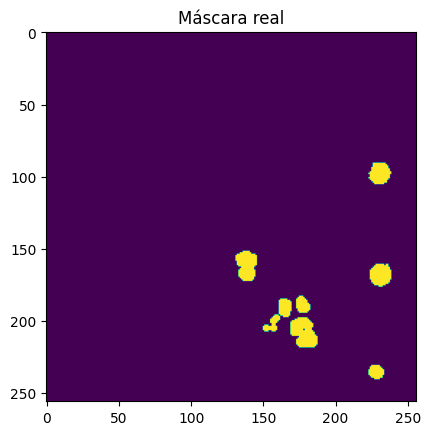

In [22]:
img_val_id = 0
img_val = X_val[img_val_id] # Imagem original
ground_truth = y_val[img_val_id] # Máscara real
plt.imshow(np.squeeze(ground_truth)) # Squeeze para retirar a dimensão adicional da máscara
plt.title("Máscara real")

In [23]:
from tensorflow.keras.metrics import MeanIoU

iou_result = MeanIoU(num_classes = 2) # 2 classes, fundo e objeto (núcleos que queremos realizar a segmentação)

In [27]:
img_val.shape

(256, 256, 3)

**Preparação da imagem para ser enviada à rede neural**

Para enviar uma imagem à rede neural, precisamos ter **4 dimensões** (**batch**, height, width, channels). Com uma única imagem, apenas temos as dimensões e número de canais, portanto, precisamos incluir mais uma dimensão, que seria a **quantidade de imagens no array** (batch).

Faremos isso com a função *expand_dims* do numpy.

In [28]:
# Aumenta as dimensões da imagem para ser compátivel com o input_shape da rede neural
val_img_input = np.expand_dims(img_val, 0)
val_img_input.shape

(1, 256, 256, 3)

In [42]:
predict = model_unet.predict(val_img_input)
predict.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


(1, 256, 256, 1)

In [43]:
predict

array([[[[0.03720747],
         [0.02690831],
         [0.02173391],
         ...,
         [0.02138225],
         [0.0223211 ],
         [0.03193332]],

        [[0.03398708],
         [0.0173955 ],
         [0.01571717],
         ...,
         [0.00859778],
         [0.01303238],
         [0.02151812]],

        [[0.02519438],
         [0.01317233],
         [0.01236214],
         ...,
         [0.00791388],
         [0.01225299],
         [0.01547233]],

        ...,

        [[0.02469133],
         [0.01474765],
         [0.00936574],
         ...,
         [0.18333596],
         [0.696224  ],
         [0.6701415 ]],

        [[0.0248792 ],
         [0.02126316],
         [0.00961465],
         ...,
         [0.15615788],
         [0.79024863],
         [0.691151  ]],

        [[0.02824362],
         [0.02256799],
         [0.01636228],
         ...,
         [0.19922675],
         [0.38250166],
         [0.33592856]]]], dtype=float32)

In [44]:
# Pegamos apenas as dimensões (altura e largura) e em seguida verificamos se o valor contido no pixel é maior do que 0.5 (que seria o objeto)
# Caso for true, será 1 (objeto), caso false será 0 (fundo)
predict = (predict[0,:,:,0] > 0.5).astype(np.uint8)
predict.shape

(256, 256)

In [45]:
predict

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Para enviar o *ground truth* (máscara real) para a métrica *IoU*, precisamos remover a informação da quantidade de canais e enviar somente as dimensões. Para isto, podemos selecionar com indexação ou com a função *np.squeeze*.

In [55]:
ground_truth.shape, ground_truth[:,:,0].shape

((256, 256, 1), (256, 256))

Relembrando que quanto mais próximo de 1, melhor é este resultado.

IoU para a imagem: 0.89245623


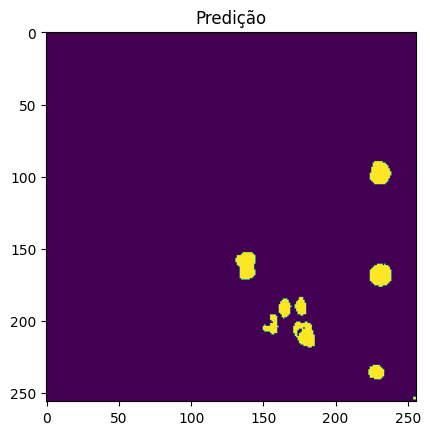

In [59]:
plt.imshow(predict)
plt.title('Predição')
iou_result.update_state(ground_truth[:,:,0], predict)

print('IoU para a imagem:', iou_result.result().numpy())

### Avaliação dos dados de validação

In [80]:
predicts_val = (predicts_val > 0.5).astype(np.uint8)

(134, 256, 256, 1)

In [88]:
predicts_val.shape, predicts_val[0][:,:,0].shape

((134, 256, 256, 1), (256, 256))

Enviamos para a função de cálculo do IoU as dimensões de largura e altura, por isso fazemos a indexação *[:,:,0]* onde adquire todos os valores da primeira e segunda coluna, porém não pega a terceira coluna (pois definimos com o valor zero).

In [89]:
results_iou_val = []

for x in range(0, len(X_val)):
    iou_result.update_state(y_val[x][:,:,0], predicts_val[x][:,:,0])
    results_iou_val.append(iou_result.result().numpy())

results_iou_val
    

[np.float32(0.90829015),
 np.float32(0.908285),
 np.float32(0.9083275),
 np.float32(0.9083897),
 np.float32(0.9084149),
 np.float32(0.9084575),
 np.float32(0.90848756),
 np.float32(0.9084996),
 np.float32(0.9083328),
 np.float32(0.9083122),
 np.float32(0.9083414),
 np.float32(0.90836585),
 np.float32(0.9085729),
 np.float32(0.90821385),
 np.float32(0.9080937),
 np.float32(0.90787846),
 np.float32(0.90802145),
 np.float32(0.90793633),
 np.float32(0.90797997),
 np.float32(0.908015),
 np.float32(0.9080539),
 np.float32(0.9080775),
 np.float32(0.9081099),
 np.float32(0.90814126),
 np.float32(0.90801793),
 np.float32(0.9081917),
 np.float32(0.9081745),
 np.float32(0.90813863),
 np.float32(0.9082308),
 np.float32(0.9081955),
 np.float32(0.9082358),
 np.float32(0.908236),
 np.float32(0.90818906),
 np.float32(0.907995),
 np.float32(0.9080457),
 np.float32(0.90802205),
 np.float32(0.90821505),
 np.float32(0.90819025),
 np.float32(0.9083686),
 np.float32(0.9083901),
 np.float32(0.9083078),
 np.f